In [18]:
import photutils, astropy
from photutils import datasets
from astropy.modeling.functional_models import Sersic2D

import numpy
import matplotlib.pyplot as plt

from astropy import visualization, convolution, stats

from collections import OrderedDict

import time

%matplotlib inline

# Level 1

## Step 1: Mock data generation

In [66]:
#model = Sersic2D(amplitude = 3, r_eff = 25, n=4, x_0=50, y_0=50,
#               ellip=.5, theta=-1)

start = time.time()
def so_far(): print(f"{time.time() - start} seconds elapsed.")

model = Sersic2D()
n_sources = 200
shape = (2000, 2000)
param_ranges = [('amplitude', [100, 200]),
                ('r_eff', [5, 35]),
                ('x_0', [0, shape[1]]),
                ('y_0', [0, shape[0]]),
                ('n', [0.8, 1.5]),
                ('ellip', [0, 0.6]),
                ('theta', [-2, 2])]
param_ranges = OrderedDict(param_ranges)
sources = datasets.make_random_models_table(n_sources, param_ranges,
                                   random_state=12344)
data = datasets.make_model_sources_image(shape, Sersic2D(), sources)

so_far()

0.0006811618804931641 seconds elapsed.


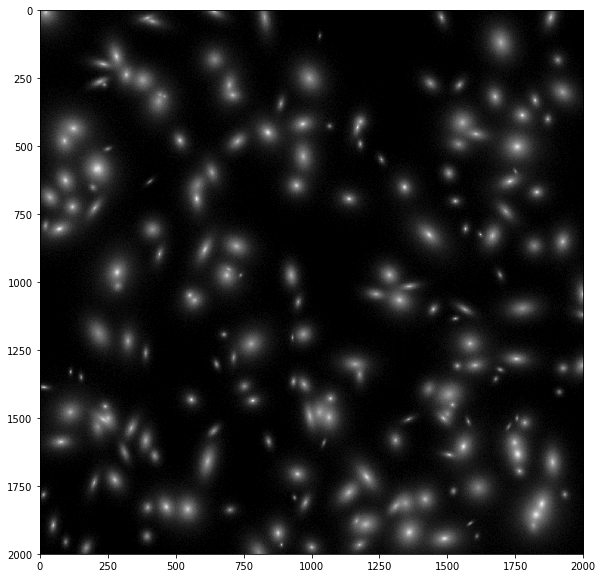

In [19]:
plt.rcParams['figure.figsize'] = [10, 10]

norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())

#plt.imshow(data)
plt.imshow(data, cmap='Greys_r', norm=norm)

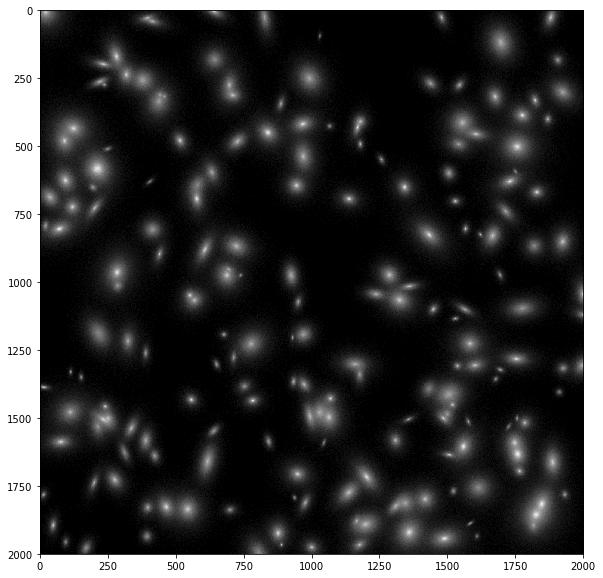

In [20]:
noise_data = datasets.apply_poisson_noise(data)
plt.imshow(noise_data, cmap='Greys_r', norm=norm)

## Step 2: Detection on mock data

In [61]:
data = noise_data
threshold = photutils.detect_threshold(data, snr=2.0)
sigma = 4.0 * stats.gaussian_fwhm_to_sigma
kernel = convolution.Gaussian2DKernel(sigma, x_size=8, y_size=8)
kernel.normalize()
segments = photutils.detect_sources(
    data, threshold, npixels=30, filter_kernel=kernel)

deblended = photutils.deblend_sources(data, segments, npixels=30, 
                               filter_kernel=kernel, nlevels=32,
                               contrast=0.001)

In [62]:
props = photutils.source_properties(data, deblended)
scale = 3.5



apertures = [photutils.EllipticalAperture(
    (i.xcentroid.value, i.ycentroid.value),
    i.semimajor_axis_sigma.value * scale,
    i.semiminor_axis_sigma.value * scale,
    theta=i.orientation.value) for i in props]

print(len(apertures), "apertures detected")

266 apertures detected


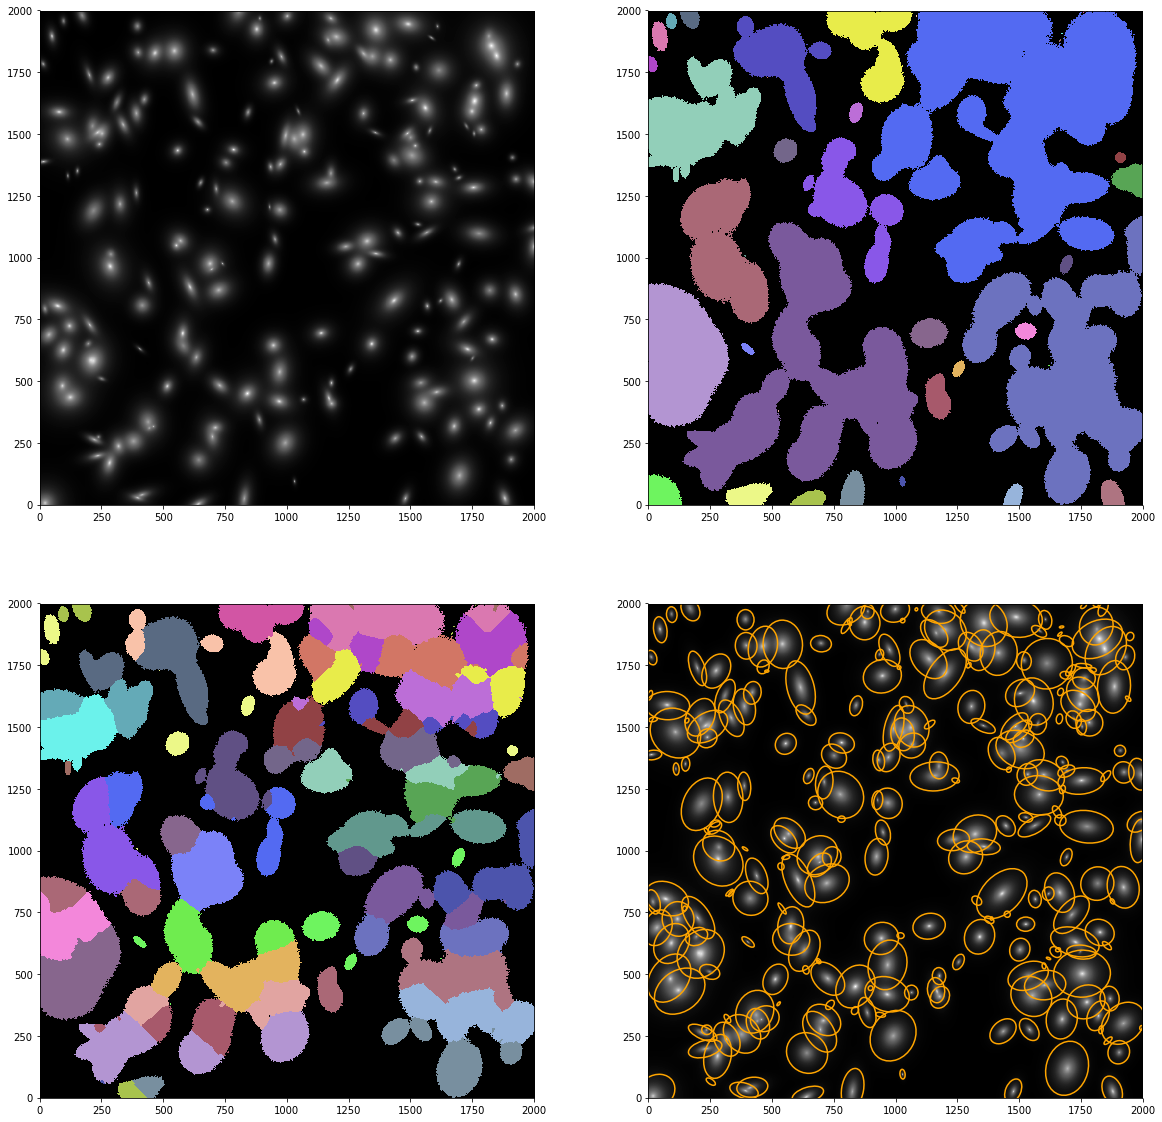

In [104]:
norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0][0].imshow(data, origin='lower', cmap='Greys_r', norm=norm)

ax[0][1].imshow(segments, origin='lower', cmap=segments.cmap(random_state=12345))
ax[1][0].imshow(deblended, origin='lower', cmap=segments.cmap(random_state=12345))

ax[1][1].imshow(data, origin='lower', cmap='Greys_r', norm=norm)
for i in apertures: i.plot(color='orange', lw=1.5, ax=ax[1][1])

In [38]:
so_far()

714.2227487564087 seconds elapsed.


## Stage 2: Removing Bright Galaxies

Text(0.5, 1.0, 'brightnesses')

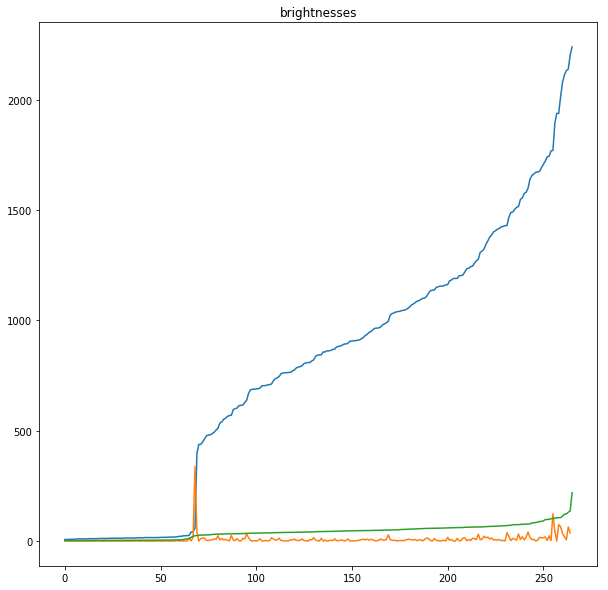

In [115]:
maxvals = sorted([i.values.max() for i in props])
diff = lambda x: [x[i] - x[i-1] for i in range(1, len(x))]

plt.plot(maxvals)
dmax = maxvals[:]
for i in range(1):
    dmax = diff(dmax)
    plt.plot(dmax)
plt.plot(sorted([i.values.mean() for i in props]))
plt.title("brightnesses")

In [135]:
def noise_threshold(v):
    sfmax = 0
    cutoff = 0
    vals = sorted([i.values.max() for i in v])
    for i in range(1, len(vals) - 1):
        delta = vals[i] - vals[i-1]
        if delta > sfmax:
            sfmax = delta
            cutoff = vals[i-1]
    return cutoff

def noise_reduce(vals):
    thresh = noise_threshold(vals)
    return list(filter(lambda x: x.values.max() >= thresh, vals))

len(noise_reduce(props))

197

197 apertures detected


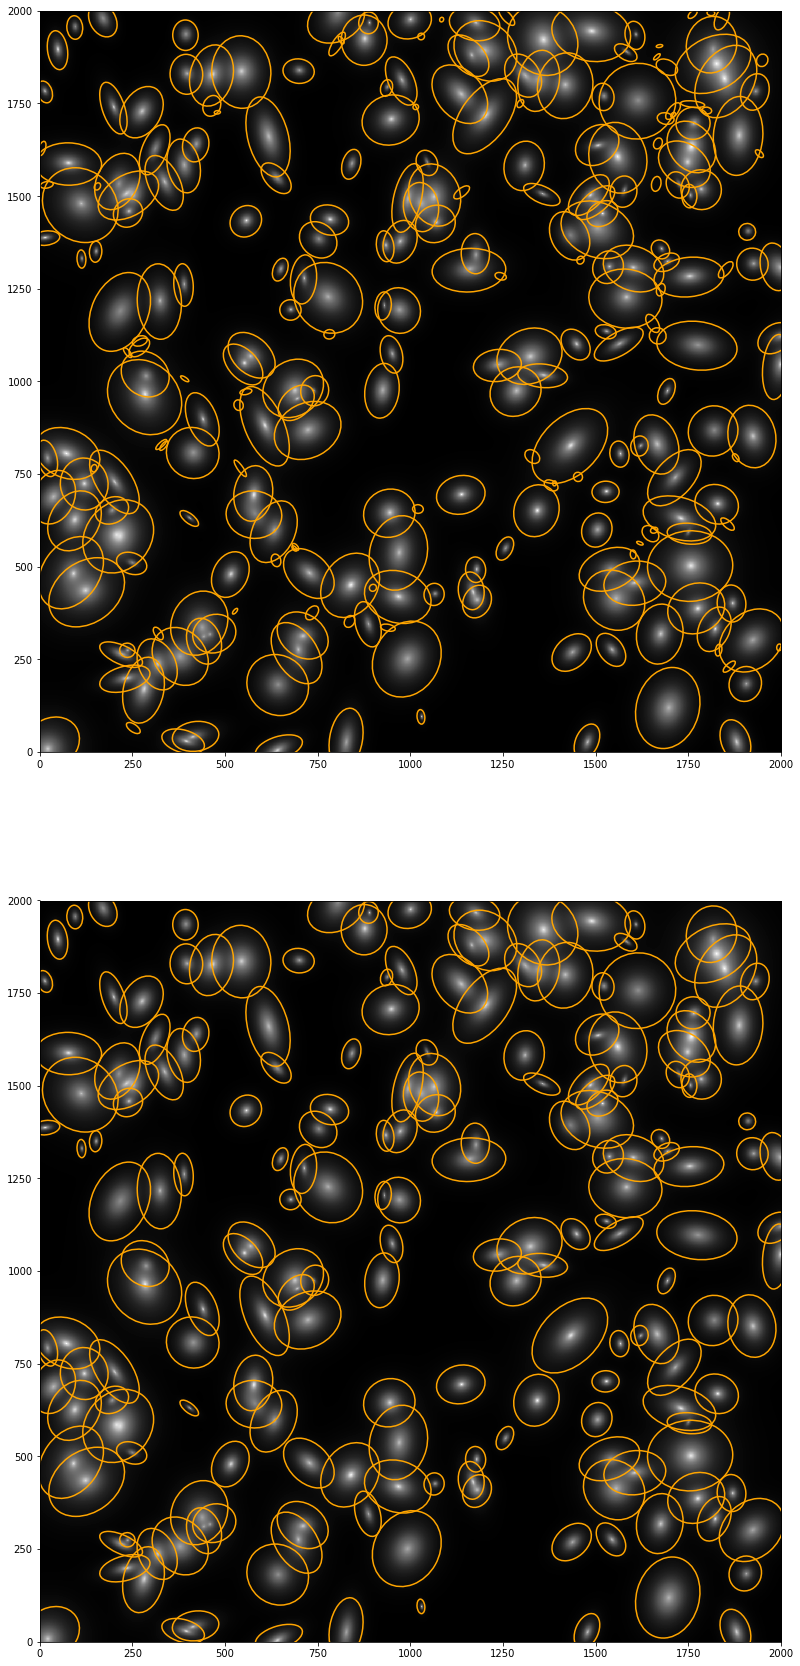

In [139]:
strained_apertures = [photutils.EllipticalAperture(
    (i.xcentroid.value, i.ycentroid.value),
    i.semimajor_axis_sigma.value * scale,
    i.semiminor_axis_sigma.value * scale,
    theta=i.orientation.value) for i in noise_reduce(props)]
print(f"{len(strained_apertures)} apertures detected")

_, ax2 = plt.subplots(2, 1, figsize=(15, 30))
ax2[0].imshow(data, origin='lower', cmap='Greys_r', norm=norm)
for i in apertures: i.plot(color='orange', lw=1.5, ax=ax2[0])
ax2[1].imshow(data, origin='lower', cmap='Greys_r', norm=norm)
for i in strained_apertures: i.plot(color='orange', lw=1.5, ax=ax2[1])